# Project: Wrangling and Analyze Data

In [1]:
! pip install tweepy


In [1]:
#import libraries
import pandas as pd 
import numpy as np
from collections import Counter
import tweepy as tp
import matplotlib.pyplot as plt
% matplotlib inline
import requests as rq
import os
import json
import datetime
from PIL import Image
from io import BytesIO
import re 
import wptools
import time
import seaborn as sns



## Data Gathering
In the cell below, gather **all** three pieces of data for this project and load them in the notebook. **Note:** the methods required to gather each data are different.
1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [2]:
twitter_archive_enhanced = pd.read_csv('twitter-archive-enhanced.csv')

2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)

In [3]:
url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
response = rq.get(url)
response.status_code

200

HTTP status code 200 indicates the request has succeeded and we acn proceed and download data.

In [4]:
with open(url.split('/')[-1] , mode='wb') as file:
    file.write(response.content)

We have successfully downloaded data from the url and saved it into a new file with the mode "wb" which indicates that the file is opened for writing in binary mode

In [3]:
image_predictions = pd.read_csv('image-predictions.tsv', sep = '\t')

In [4]:
image_predictions.head(2)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True


3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

The Twitter API requires that all requests use OAuth to authenticate. So we've created the required authentication credentials to be able to use the API. 


In [40]:
# API key
API_key = #inset
#API secret key
API_secret = #inset
#Access token
access_token = #inset
#Access token secret
access_secret = #inset

In [41]:
# Authenticate to Twitter
auth = tp.OAuthHandler(API_key, API_secret)
auth.set_access_token(access_token, access_secret)

# Create API object
api = tp.API(auth , wait_on_rate_limit=True)

In [42]:
try:
    api.verify_credentials()
    print("Authentication OK")
except:
    print("Error during authentication")

Authentication OK


In [73]:
#Check how many queries you have left using rate_limit_status() method
api.rate_limit_status()['resources']['search']

{'/search/tweets': {'limit': 180, 'remaining': 180, 'reset': 1662508003}}

In [331]:
list_tweet_id = list(twitter_archive_enhanced.tweet_id)

In [125]:
# function to extract data from tweet's id and save file
def tweet_json(list_tweet_id , file_name):

    fail = {}
    start_time = time.time()
    count = 0

    with open(file_name, 'w') as file:
        for tweet_id in list_tweet_id:
            count = count + 1
            try:
                tweet = api.get_status(tweet_id, tweet_mode="extended")
                json.dump(tweet._json, file)
                file.write('\n')
            except tp.TweepError as e:
                print('Failed to load data from this tweet id :'+ str(tweet_id))
                fails[tweet_id] = e
                pass
            if (count % 180) == 0:
                time.sleep(5) #sleep for 5 seconds to avoid the server to be overloaded with too many requests
    
    run_time = time.time() - start_time
    mnt = run_time // 60
    sec = run_time % 60

    print("---%02d:%02d---" % (mnt, sec))

    return(file)


In [127]:
tweet_json(list_tweet_id , 'tweet_json.txt')

Failed to load data from this tweet id :888202515573088257
Failed to load data from this tweet id :873697596434513921
Failed to load data from this tweet id :872668790621863937
Failed to load data from this tweet id :872261713294495745
Failed to load data from this tweet id :869988702071779329
Failed to load data from this tweet id :866816280283807744
Failed to load data from this tweet id :861769973181624320
Failed to load data from this tweet id :856602993587888130
Failed to load data from this tweet id :856330835276025856
Failed to load data from this tweet id :851953902622658560
Failed to load data from this tweet id :851861385021730816
Failed to load data from this tweet id :845459076796616705
Failed to load data from this tweet id :844704788403113984
Failed to load data from this tweet id :842892208864923648
Failed to load data from this tweet id :837366284874571778
Failed to load data from this tweet id :837012587749474308
Failed to load data from this tweet id :8293743416913469

<_io.TextIOWrapper name='tweet_json.txt' mode='w' encoding='UTF-8'>

In [132]:
with open('tweet_json.txt') as f:
    first_line = json.loads(f.readline())

In [134]:
first_line.keys()

dict_keys(['created_at', 'id', 'id_str', 'full_text', 'truncated', 'display_text_range', 'entities', 'extended_entities', 'source', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'user', 'geo', 'coordinates', 'place', 'contributors', 'is_quote_status', 'retweet_count', 'favorite_count', 'favorited', 'retweeted', 'possibly_sensitive', 'possibly_sensitive_appealable', 'lang'])

After incpecting a tweet's info theresn't much needed data to get other than tweet id, retweet count and favorite count for the study.


In [135]:
first_line['id'], first_line['retweet_count'], first_line['favorite_count']

(892420643555336193, 6969, 33695)

In [186]:
tweet_id = []
retweet_count = []
favorite_count = []

with open('tweet_json.txt', 'r') as json_file:  #read tweet's JSON data line by line and later create to a DataFrame
    for line in json_file:
        json_line = json.loads(line)
        tweet_id.append(json_line['id'])
        retweet_count.append(json_line['retweet_count'])
        favorite_count.append(json_line['favorite_count'])


In [187]:
#Create a DataFrame with tweet ID, retweet count, favorite count
tweet_df = pd.DataFrame({'tweet_id':tweet_id, 'retweet_count':retweet_count, 'favorite_count':favorite_count})

In [5]:
def save_to_csv(filename,dataframe):
    dataframe.to_csv(filename+'.csv', index = False, header=True, sep=';',encoding='utf-8')

In [21]:
save_to_csv('tweets',tweet_df)

## Assessing Data
In this section, detect and document at least **eight (8) quality issues and two (2) tidiness issue**. You must use **both** visual assessment
programmatic assessement to assess the data.

**Note:** pay attention to the following key points when you access the data.

* You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
* Assessing and cleaning the entire dataset completely would require a lot of time, and is not necessary to practice and demonstrate your skills in data wrangling. Therefore, the requirements of this project are only to assess and clean at least 8 quality issues and at least 2 tidiness issues in this dataset.
* The fact that the rating numerators are greater than the denominators does not need to be cleaned. This [unique rating system](http://knowyourmeme.com/memes/theyre-good-dogs-brent) is a big part of the popularity of WeRateDogs.
* You do not need to gather the tweets beyond August 1st, 2017. You can, but note that you won't be able to gather the image predictions for these tweets since you don't have access to the algorithm used.



### Assessing Data in enhanced-twitter-archive.csv


In [8]:
twitter_archive_enhanced

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [202]:
#Assessing the column text
twitter_archive_enhanced.iloc[2335]['text']

'This is an Albanian 3 1/2 legged  Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv'

In [203]:
twitter_archive_enhanced.iloc[2335]['rating_numerator']

1

* The two pieces of code above show us that the value in the column rating_numerator is different than the one mentioned in the  text.

In [15]:
# general info about th dataset such as data type and amount of non-null variables
twitter_archive_enhanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

This dataset contains 2356 rows and 17 columns.
We notice that we need to :
* Change datatype for the columns in_reply_to_status_id, in_reply_to_user_id into integer instead of float.
* Change datatype for the column timestamp into datetime.
* Combine columns doggo, floofer, pupper, puppo into category and change datatype .
* Drop the columns retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp,in_reply_to_status_id and in_reply_to_user_id  since there are alot of missing values and also we aren't intrested in tweets reply or retweet.
* Drop the columns in_reply_to_status_id and in_reply_to_user_id there the dataset contains only 78 non-null values .
* Some missing data in the column expanded_urls.


In [16]:
#statistical info for numerical columns in the dataframe
twitter_archive_enhanced.describe() 


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


Only the variables rating_numerator and rating_denominator matters in this statistical summary.
We can notice that rating_numerator has a minimum 0 and a maximum 1776, while the rating_denominator has also a minimum 0 and a maximum 170, also having minimum value 0 for the rating_denominator isn't right .


In [29]:
#check for duplicated rows
len(twitter_archive_enhanced[twitter_archive_enhanced.duplicated()])

0

In [9]:
twitter_archive_enhanced.name.value_counts() 

None         745
a             55
Charlie       12
Lucy          11
Oliver        11
Cooper        11
Lola          10
Penny         10
Tucker        10
Bo             9
Winston        9
the            8
Sadie          8
Toby           7
Bailey         7
Daisy          7
an             7
Buddy          7
Koda           6
Oscar          6
Jack           6
Bella          6
Stanley        6
Leo            6
Rusty          6
Jax            6
Dave           6
Scout          6
Milo           6
Sunny          5
            ... 
Bayley         1
Hall           1
Alf            1
Sonny          1
Geoff          1
Gerbald        1
Spark          1
Kona           1
Murphy         1
Tayzie         1
Binky          1
DayZ           1
Ralphé         1
Al             1
Scott          1
Kayla          1
such           1
Jerome         1
Mookie         1
Yukon          1
Erik           1
Kenzie         1
Maxwell        1
Rolf           1
Suki           1
Zeus           1
Combo          1
Genevieve     

In [20]:
#twitter_archive_enhanced.name.str.lower().unique()

* It's a bit weird to have a dog's name 'a' or 'the' or 'such' so there might be a misstype when entering the data, not forgetting the 'None' dog name.The is to extract the names in lower case and get the intersection of both .

In [26]:
list(set(twitter_archive_enhanced.name.unique()) & set(twitter_archive_enhanced.name.str.lower().unique()))

['this',
 'one',
 'the',
 'light',
 'life',
 'space',
 'mad',
 'very',
 'an',
 'incredibly',
 'his',
 'officially',
 'old',
 'all',
 'getting',
 'a',
 'infuriating',
 'by',
 'my',
 'such',
 'not',
 'actually',
 'quite',
 'unacceptable',
 'just']

In [86]:
print('There is %2d incorrect dog name.' % len(list(set(twitter_archive_enhanced.name.unique()) & set(twitter_archive_enhanced.name.str.lower().unique()))))

There is 25 incorrect dog name.


In [22]:
twitter_archive_enhanced.source[0]

'<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>'

In [41]:
twitter_archive_enhanced.source.unique()


array([ '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
       '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>',
       '<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>',
       '<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>'], dtype=object)

* The column source contains a HTML code ,we need to first extract the text data from the HTML code and then change the datatype into category. 



In [47]:
twitter_archive_enhanced.text[404]

'"I wish we were dogs" 14/10 for @BadlandsNPS https://t.co/50qq2DItPW'

* Tweeet text contains link, some of them aren't valid .

In [28]:
twitter_archive_enhanced.doggo.value_counts()

None     2259
doggo      97
Name: doggo, dtype: int64

In [29]:
twitter_archive_enhanced.floofer.value_counts()

None       2346
floofer      10
Name: floofer, dtype: int64

In [30]:
twitter_archive_enhanced.pupper.value_counts()

None      2099
pupper     257
Name: pupper, dtype: int64

In [31]:
twitter_archive_enhanced.puppo.value_counts()

None     2326
puppo      30
Name: puppo, dtype: int64

* We might need to create an other column stage to avoid all the missing data in the columns doggo, floofer, pupper and puppo and drop those.

In [87]:
print('There is %2d null values in the column expanded_urls.' %sum(twitter_archive_enhanced.expanded_urls.isnull()) )

There is 59 null values in the column expanded_urls.


In [88]:
#Number of tweets this missing urls and in the same time retweets or reply to tweet
twitter_archive_enhanced[((twitter_archive_enhanced.expanded_urls.isnull()) & twitter_archive_enhanced.retweeted_status_id.isnull()) &
                         ((twitter_archive_enhanced.expanded_urls.isnull()) & twitter_archive_enhanced.in_reply_to_status_id.isnull())]



,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
375,828361771580813312,NaN,NaN,2017-02-05 21:56:51 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",Beebop and Doobert should start a band 12/10 w...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
707,785515384317313025,NaN,NaN,2016-10-10 16:20:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...","Today, 10/10, should be National Dog Rates Day",NaN,NaN,NaN,NaN,10,10,None,None,None,None,None
1445,696518437233913856,NaN,NaN,2016-02-08 02:18:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Oh my god 10/10 for every little hot dog pupper,NaN,NaN,NaN,NaN,10,10,None,None,None,pupper,None


In [89]:
len(twitter_archive_enhanced[((twitter_archive_enhanced.expanded_urls.isnull()) & twitter_archive_enhanced.retweeted_status_id.isnull()) &
                         ((twitter_archive_enhanced.expanded_urls.isnull()) & twitter_archive_enhanced.in_reply_to_status_id.isnull())])

3

In [90]:
t_i = twitter_archive_enhanced[((twitter_archive_enhanced.expanded_urls.isnull()) & twitter_archive_enhanced.retweeted_status_id.isnull()) &
                         ((twitter_archive_enhanced.expanded_urls.isnull()) & twitter_archive_enhanced.in_reply_to_status_id.isnull())].tweet_id


In [99]:
for id_t in t_i :
    if (id_t in image_predictions.tweet_id ):
        print('%2d exists' %id_t)
    else :
        print(" %2d dosen't exist in image_predections" %id_t)

 828361771580813312 dosen't exist in image_predections
 785515384317313025 dosen't exist in image_predections
 696518437233913856 dosen't exist in image_predections


* We have only 3 tweets that have a missing value in the column expanded_urls that aren't related to tweet reply or retweets but they aren't in the table image_predictions while they exist in tweet_df but this is just for analysing we won't drop them since we won't use these urls some of thems don't work.

In [11]:
twitter_archive_enhanced.rating_numerator.unique() 
#Notice unreal ratings !

array([  13,   12,   14,    5,   17,   11,   10,  420,  666,    6,   15,
        182,  960,    0,   75,    7,   84,    9,   24,    8,    1,   27,
          3,    4,  165, 1776,  204,   50,   99,   80,   45,   60,   44,
        143,  121,   20,   26,    2,  144,   88])

In [114]:
twitter_archive_enhanced[twitter_archive_enhanced.in_reply_to_status_id.isnull() | twitter_archive_enhanced.retweeted_status_id.isnull()].rating_numerator.unique()
#these values are going to be deleted anyway

array([  13,   12,   14,    5,   17,   11,   10,  420,  666,    6,   15,
        182,  960,    0,   75,    7,   84,    9,   24,    8,    1,   27,
          3,    4,  165, 1776,  204,   50,   99,   80,   45,   60,   44,
        143,  121,   20,   26,    2,  144,   88])

In [21]:
twitter_archive_enhanced[twitter_archive_enhanced['rating_numerator'] == 1776] #check the row with the max of rating_numerator

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
979,749981277374128128,NaN,NaN,2016-07-04 15:00:45 +0000,"<a href=""https://about.twitter.com/products/tw...",This is Atticus. He's quite simply America af....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/749981277...,1776,10,Atticus,None,None,None,None


Since we are only intreseted with rating_denominator equal to 10 ,we will see the destribution values of rating_numerator.

In [151]:
twitter_archive_enhanced[ twitter_archive_enhanced.rating_denominator == 10 ].rating_numerator.value_counts().sort_index(ascending = False)

1776      1
666       1
420       2
182       1
75        2
27        1
26        1
17        1
15        2
14       54
13      351
12      558
11      463
10      461
9       156
8       102
7        54
6        32
5        37
4        15
3        19
2         9
1         8
0         2
Name: rating_numerator, dtype: int64

In [164]:
#Check rows with the condition rating_numerator value superior to 15 and the condition that the rating_denominator value uqual to 10
twitter_archive_enhanced[ (twitter_archive_enhanced.rating_denominator == 10) & (twitter_archive_enhanced.rating_numerator > 15) ]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
55,881633300179243008,8.816070e+17,47384430.0,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@roushfenway These are good dogs but 17/10 is ...,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None
188,855862651834028034,8.558616e+17,194351775.0,2017-04-22 19:15:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@dhmontgomery We also gave snoop dogg a 420/10...,NaN,NaN,NaN,NaN,420,10,None,None,None,None,None
189,855860136149123072,8.558585e+17,13615722.0,2017-04-22 19:05:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@s8n You tried very hard to portray this good ...,NaN,NaN,NaN,NaN,666,10,None,None,None,None,None
290,838150277551247360,8.381455e+17,21955058.0,2017-03-04 22:12:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@markhoppus 182/10,NaN,NaN,NaN,NaN,182,10,None,None,None,None,None
340,832215909146226688,NaN,NaN,2017-02-16 13:11:49 +0000,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: This is Logan, the Chow who liv...",7.867091e+17,4.196984e+09,2016-10-13 23:23:56 +0000,https://twitter.com/dog_rates/status/786709082...,75,10,Logan,None,None,None,None
695,786709082849828864,NaN,NaN,2016-10-13 23:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...","This is Logan, the Chow who lived. He solemnly...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/786709082...,75,10,Logan,None,None,None,None
763,778027034220126208,NaN,NaN,2016-09-20 00:24:34 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Sophie. She's a Jubilant Bush Pupper. ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/778027034...,27,10,Sophie,None,None,pupper,None
979,749981277374128128,NaN,NaN,2016-07-04 15:00:45 +0000,"<a href=""https://about.twitter.com/products/tw...",This is Atticus. He's quite simply America af....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/749981277...,1776,10,Atticus,None,None,None,None
1712,680494726643068929,NaN,NaN,2015-12-25 21:06:00 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have uncovered an entire battalion of ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/680494726...,26,10,None,None,None,None,None
2074,670842764863651840,NaN,NaN,2015-11-29 05:52:33 +0000,"<a href=""http://twitter.com/download/iphone"" r...",After so many requests... here you go.\n\nGood...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/670842764...,420,10,None,None,None,None,None


In [176]:
twitter_archive_enhanced[ (twitter_archive_enhanced.rating_denominator == 10) & (twitter_archive_enhanced.rating_numerator > 15) & (~twitter_archive_enhanced.in_reply_to_status_id.isnull()) |
                           (twitter_archive_enhanced.rating_denominator == 10) & (twitter_archive_enhanced.rating_numerator > 15) & (~twitter_archive_enhanced.retweeted_status_id.isnull())  ]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
55,881633300179243008,8.816070e+17,47384430.0,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@roushfenway These are good dogs but 17/10 is ...,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None
188,855862651834028034,8.558616e+17,194351775.0,2017-04-22 19:15:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@dhmontgomery We also gave snoop dogg a 420/10...,NaN,NaN,NaN,NaN,420,10,None,None,None,None,None
189,855860136149123072,8.558585e+17,13615722.0,2017-04-22 19:05:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@s8n You tried very hard to portray this good ...,NaN,NaN,NaN,NaN,666,10,None,None,None,None,None
290,838150277551247360,8.381455e+17,21955058.0,2017-03-04 22:12:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@markhoppus 182/10,NaN,NaN,NaN,NaN,182,10,None,None,None,None,None
340,832215909146226688,NaN,NaN,2017-02-16 13:11:49 +0000,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: This is Logan, the Chow who liv...",7.867091e+17,4.196984e+09,2016-10-13 23:23:56 +0000,https://twitter.com/dog_rates/status/786709082...,75,10,Logan,None,None,None,None


In [182]:
print( "This dataset contains exactly%2d rows with unreal rating_numerator values after exculding the ones with non-values replies or retweets ." %len( twitter_archive_enhanced[ (twitter_archive_enhanced.rating_denominator == 10) & (twitter_archive_enhanced.rating_numerator > 15) & (~twitter_archive_enhanced.in_reply_to_status_id.isnull()) |
                           (twitter_archive_enhanced.rating_denominator == 10) & (twitter_archive_enhanced.rating_numerator > 15) & (~twitter_archive_enhanced.retweeted_status_id.isnull())  ] ) )

This dataset contains exactly 5 rows with unreal rating_numerator values after exculding the ones with non-values replies or retweets .


In [288]:
twitter_archive_enhanced.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [299]:
len(twitter_archive_enhanced[twitter_archive_enhanced['rating_denominator'] != 10])

23

The data description cited that denominator is generally 10 so we aren't taking those different from 10 in consideration. 
There is 23 rows with rating_denominator different to 10 in this dataset .
We are interested to see if these rating_denominator are related to original tweets or reply or the retweeted ones.Since we are dropping the data about retweets we need to check the original tweets to see if we might need to drop those tweet_id from image_predictions table  and tweet_json table .


In [53]:
twitter_archive_enhanced[((twitter_archive_enhanced.rating_denominator != 10) & ~twitter_archive_enhanced.retweeted_status_id.isnull()) | ((twitter_archive_enhanced.rating_denominator != 10) & ~twitter_archive_enhanced.in_reply_to_status_id.isnull())]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
313,835246439529840640,8.352460e+17,2.625958e+07,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@jonnysun @Lin_Manuel ok jomny I know you're e...,NaN,NaN,NaN,NaN,960,0,None,None,None,None,None
342,832088576586297345,8.320875e+17,3.058208e+07,2017-02-16 04:45:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@docmisterio account started on 11/15/15,NaN,NaN,NaN,NaN,11,15,None,None,None,None,None
784,775096608509886464,NaN,NaN,2016-09-11 22:20:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: After so many requests, this is...",7.403732e+17,4.196984e+09,2016-06-08 02:41:38 +0000,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None
1598,686035780142297088,6.860340e+17,4.196984e+09,2016-01-10 04:04:10 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Yes I do realize a rating of 4/20 would've bee...,NaN,NaN,NaN,NaN,4,20,None,None,None,None,None
1634,684225744407494656,6.842229e+17,4.196984e+09,2016-01-05 04:11:44 +0000,"<a href=""http://twitter.com/download/iphone"" r...","Two sneaky puppers were not initially seen, mo...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/684225744...,143,130,None,None,None,None,None
1663,682808988178739200,6.827884e+17,4.196984e+09,2016-01-01 06:22:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...","I'm aware that I could've said 20/16, but here...",NaN,NaN,NaN,NaN,20,16,None,None,None,None,None


In [54]:
twitter_archive_enhanced[((twitter_archive_enhanced.rating_denominator != 10) & ~twitter_archive_enhanced.retweeted_status_id.isnull()) | ((twitter_archive_enhanced.rating_denominator != 10) & ~twitter_archive_enhanced.in_reply_to_status_id.isnull())].rating_denominator.unique()

array([  0,  15,  11,  20, 130,  16])

In [55]:
len(twitter_archive_enhanced[((twitter_archive_enhanced.rating_denominator != 10) & ~twitter_archive_enhanced.retweeted_status_id.isnull()) | ((twitter_archive_enhanced.rating_denominator != 10) & ~twitter_archive_enhanced.in_reply_to_status_id.isnull())].rating_denominator.unique())

6

* We have only 6 tweets that have a rating denominator value different from 10  in the column rating_denominator for original tweets.

In [185]:
twitter_archive_enhanced.doggo.value_counts() 

None     2259
doggo      97
Name: doggo, dtype: int64

In [186]:
twitter_archive_enhanced.floofer.value_counts() 

None       2346
floofer      10
Name: floofer, dtype: int64

In [187]:
twitter_archive_enhanced.pupper.value_counts() 

None      2099
pupper     257
Name: pupper, dtype: int64

In [188]:
twitter_archive_enhanced.puppo.value_counts() 

None     2326
puppo      30
Name: puppo, dtype: int64

* While investigating the dataset we haven't found null values, but this proves the it does contain alot of null-values.

In [194]:
twitter_archive_enhanced.iloc[956] #one dog cant't have different types 

"Please stop sending it pictures that don't even have a doggo or pupper in them. Churlish af. 5/10 neat couch tho https://t.co/u2c9c7qSg8"

In [199]:
image_predictions.query('tweet_id == 751583847268179968')


,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1292,751583847268179968,https://pbs.twimg.com/media/Cm4phTpWcAAgLsr.jpg,1,dalmatian,0.868304,True,studio_couch,0.059623,False,snow_leopard,0.013876,False


* Some dogs have 2 dog types we might drop those rows.

### Assessing Data in image-predictions.csv
 

In [201]:
image_predictions

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [204]:
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


* This dataset contains 2075 rows and 12 columns.

* There is no missing columns in this dataset. But we notice that this size of the dataset and the previous one ,twitter_archive_enhanced aren't the same and since these two datasets are related (tweet_id), we can say that there are missing rows.


In [205]:
image_predictions.describe() #theresn't much things to conclude for the assess part from this statistical description

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [209]:
image_predictions.p1.unique() 

array(['Welsh_springer_spaniel', 'redbone', 'German_shepherd',
       'Rhodesian_ridgeback', 'miniature_pinscher', 'Bernese_mountain_dog',
       'box_turtle', 'chow', 'shopping_cart', 'miniature_poodle',
       'golden_retriever', 'Gordon_setter', 'Walker_hound', 'pug',
       'bloodhound', 'Lhasa', 'English_setter', 'hen', 'desktop_computer',
       'Italian_greyhound', 'Maltese_dog', 'three-toed_sloth', 'ox',
       'malamute', 'guinea_pig', 'soft-coated_wheaten_terrier',
       'Chihuahua', 'black-and-tan_coonhound', 'coho', 'toy_terrier',
       'Blenheim_spaniel', 'Pembroke', 'llama', 'Chesapeake_Bay_retriever',
       'curly-coated_retriever', 'dalmatian', 'Ibizan_hound',
       'Border_collie', 'Labrador_retriever', 'seat_belt', 'snail',
       'miniature_schnauzer', 'Airedale', 'triceratops', 'swab', 'hay',
       'hyena', 'jigsaw_puzzle', 'West_Highland_white_terrier',
       'toy_poodle', 'giant_schnauzer', 'vizsla', 'vacuum', 'Rottweiler',
       'Siberian_husky', 'teddy', 

* We notice that there are multiple values in the columns p1, p2 and p3  that aren't dogs , we need to first extrat the dog predicted then create a new column that contain these information and then drop those columns.

* Following the same methodology used to exclude the illogical dog names , here we are going to check the disjoint of the original names and the lower case ones.This step will help in the creation of the new columns to make sure that it contains dog types. 

In [223]:
image_predictions.p1.unique().sort() == image_predictions.p3.unique().sort()
#check if we have the same dogs

True

In [222]:
image_predictions.p1.unique().sort() == image_predictions.p2.unique().sort()


True

In [218]:
list(set(image_predictions.p1.unique()) - set(image_predictions.p1.str.lower().unique()))

['Saint_Bernard',
 'English_springer',
 'Angora',
 'Siamese_cat',
 'African_crocodile',
 'Australian_terrier',
 'Japanese_spaniel',
 'Border_collie',
 'Arctic_fox',
 'African_grey',
 'Pembroke',
 'Boston_bull',
 'Christmas_stocking',
 'Tibetan_terrier',
 'Shetland_sheepdog',
 'Scottish_deerhound',
 'Gordon_setter',
 'Italian_greyhound',
 'American_black_bear',
 'EntleBucher',
 'Staffordshire_bullterrier',
 'Pomeranian',
 'Brabancon_griffon',
 'Irish_terrier',
 'Weimaraner',
 'German_shepherd',
 'Doberman',
 'Greater_Swiss_Mountain_dog',
 'Ibizan_hound',
 'Yorkshire_terrier',
 'Blenheim_spaniel',
 'Sussex_spaniel',
 'Leonberg',
 'Brittany_spaniel',
 'Rottweiler',
 'English_setter',
 'Mexican_hairless',
 'Siberian_husky',
 'Maltese_dog',
 'Border_terrier',
 'Norwegian_elkhound',
 'Madagascar_cat',
 'Cardigan',
 'Loafer',
 'Shih-Tzu',
 'American_Staffordshire_terrier',
 'Egyptian_cat',
 'Bedlington_terrier',
 'Norfolk_terrier',
 'Irish_setter',
 'Labrador_retriever',
 'Great_Pyrenees',
 '

### Assessing Data int Enhanced tweet_json.txt


In [227]:
tweet_df.head()

,tweet_id,retweet_count,favorite_count
0,892420643555336193,6969,33695
1,892177421306343426,5272,29218
2,891815181378084864,3464,21974
3,891689557279858688,7191,36785
4,891327558926688256,7715,35177


In [229]:
tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2327 entries, 0 to 2326
Data columns (total 3 columns):
tweet_id          2327 non-null int64
retweet_count     2327 non-null int64
favorite_count    2327 non-null int64
dtypes: int64(3)
memory usage: 54.6 KB


* We notice that this dataset contains missing rows and this is because when we extracted retweet_count and favorite_count from twitter using tweet_id an error was thrown and we couldn't accomplish that task. 
* Since we don't have duplicated tweet_id in the dataframe  twitter_archive_enhanced ,there won't be duplicated tweet_id.
* Change datatype for tweet_id.

### Quality issues

##### `twitter_archive_enhanced` table


* Erroneous datatypes (timestamp, source , rating_numerator, rating_denominator ).
* Clean text column.
* Only original tweets.
* Incorrect values in the column source hidden in HTML code.
* Incorrect values in the column name.
* Incorrect values in the column rating_numerator, rating_denominator.
* Convert the string "None" to a proper None .(Unknown)


##### `image_predictions` table

* Erroneous datatypes of new created column dog_stage.

* Incorrect predictions in p1, p2 and p3.

* Missing rows (2075 instead of 2356).



##### `tweet_df` table

* Missing rows (2327 instead of 2356).


### Tidiness issues

##### `twitter_archive_enhanced` table

* Create new column dog_stage instead 4 different columns (doggo, floofer, pupper, and puppo).
* Drop unnecessary columns.


##### `image_predictions` table

* Create new column dog_breed instead 3 different columns (p1, p2 and p3).

##### `tweet_df` table
 
* Combine tweet_df and twitter_archive_enhanced and image_redictions.


## Cleaning Data

**Note:** At this part we will solve sometimes both qulity and tidiness problems.

In [9]:
# Make copies of original pieces of data
twitter_archive_enhanced_copy = twitter_archive_enhanced.copy()
image_predictions_copy = image_predictions.copy()
tweet_df_copy = tweet_df.copy()

### Issue #1: Convert the string "None" to a proper None & create a new column

##### Define:

* Convert the string "None" to a proper None in the columns name ,doggo ,floofer ,pupper ,puppo and merge the last four into one column.

##### Code

In [10]:
len(twitter_archive_enhanced_copy[twitter_archive_enhanced_copy.name == 'None'])

745

In [11]:
twitter_archive_enhanced_copy.doggo.value_counts()

None     2259
doggo      97
Name: doggo, dtype: int64

In [12]:
twitter_archive_enhanced_copy.pupper.value_counts()

None      2099
pupper     257
Name: pupper, dtype: int64

In [13]:
twitter_archive_enhanced_copy.name.replace("None", 'Unknown', inplace = True) #we are replacing 'None' with Uknown

In [14]:
#this is not going to be the same as above because we are going to replace the None tring and creat another column by concatenating
twitter_archive_enhanced_copy.doggo.replace("None", '', inplace = True) 
twitter_archive_enhanced_copy.floofer.replace("None", '', inplace = True)
twitter_archive_enhanced_copy.pupper.replace("None", '', inplace = True)
twitter_archive_enhanced_copy.puppo.replace("None", '', inplace = True)

In [15]:
twitter_archive_enhanced_copy['dog_stage'] = twitter_archive_enhanced_copy.doggo+twitter_archive_enhanced_copy.floofer+twitter_archive_enhanced_copy.pupper+twitter_archive_enhanced_copy.puppo


In [16]:
twitter_archive_enhanced_copy.dog_stage.replace('', 'Unknown', inplace = True)

In [17]:
twitter_archive_enhanced_copy.drop(['doggo', 'floofer', 
                'pupper', 'puppo'], axis=1, inplace=True)

In [18]:
twitter_archive_enhanced_copy.dog_stage.value_counts()

Unknown         1976
pupper           245
doggo             83
puppo             29
doggopupper       12
floofer            9
doggofloofer       1
doggopuppo         1
Name: dog_stage, dtype: int64

As we noticed in the asswssing part there are rows have 2 dog types and floofer is the least dog type existing  in this dataset .we willchange those which have 2 types to Unknown.

In [19]:
#change doggopupper,doggopuppo, doggofloofer to Unknown

twitter_archive_enhanced_copy.loc[twitter_archive_enhanced_copy.dog_stage == 'doggopupper', 'dog_stage'] = 'Unknown'
twitter_archive_enhanced_copy.loc[twitter_archive_enhanced_copy.dog_stage == 'doggofloofer', 'dog_stage'] = 'Unknown'
twitter_archive_enhanced_copy.loc[twitter_archive_enhanced_copy.dog_stage == 'doggopuppo', 'dog_stage'] = 'Unknown'


##### Test

In [20]:
len(twitter_archive_enhanced_copy[twitter_archive_enhanced_copy.name == 'None'])

0

In [21]:
twitter_archive_enhanced_copy.dog_stage.value_counts()

Unknown    1990
pupper      245
doggo        83
puppo        29
floofer       9
Name: dog_stage, dtype: int64

In [22]:
twitter_archive_enhanced_copy.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'dog_stage'],
      dtype='object')

### Issue #2: Incorrect values in the column source hidden in HTML code

##### Define:

* Extract the source from the HTML code.

##### Code


In [23]:
twitter_archive_enhanced_copy.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [24]:
twitter_archive_enhanced_copy.source = twitter_archive_enhanced_copy.source.apply(lambda x :x.split('>')[1][:-3])

##### Test


In [25]:
twitter_archive_enhanced_copy.source.value_counts()

Twitter for iPhone     2221
Vine - Make a Scene      91
Twitter Web Client       33
TweetDeck                11
Name: source, dtype: int64

### Issue #3: Incorrect values in the column rating_numerator, rating_denominator and Clean text column

##### Define:

* Drop all values of rating_denominator different to 10 and correct rating_numerator values. These correct rating_numerator are in the column text and to extract them we need to clean the data in that column by removing links . 

##### Code


In [26]:
twitter_archive_enhanced_copy.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [27]:
twitter_archive_enhanced_copy.drop(twitter_archive_enhanced_copy[twitter_archive_enhanced_copy['rating_denominator'] != 10].index, axis=0 , inplace = True)

In [28]:
twitter_archive_enhanced_copy.text[0]

"This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU"

Now we are cleaning the column text in order to extract the correct rating_numerator.At this phase we are removie hashtags and "#hashtag" and usernames "@" because they maight have numbers in them which can mistake us to get the correct ratings .

In [29]:
twitter_archive_enhanced_copy.text = twitter_archive_enhanced_copy.text.apply(lambda x : re.sub(r'http\S+', '', x) )

In [30]:
twitter_archive_enhanced_copy.text = twitter_archive_enhanced_copy.text.apply(lambda x : re.sub(r'@\S+', '', x) )

In [31]:
def correct (ms) :
    res = re.findall(r"[-+]?(?:\d*\.\d+|\d+)", ms)
    if(len(res) == 4):
        return res[2]
    elif(len(res) == 3):
        return res[1]
    else:
        return res[0]

In [32]:
twitter_archive_enhanced_copy.rating_numerator = twitter_archive_enhanced_copy.text.apply(lambda x : correct(x) )

In [33]:
twitter_archive_enhanced_copy.rating_numerator.value_counts()

12       551
11       458
10       448
13       350
9        151
8        103
7         55
14        54
6         33
5         33
3         19
4         16
1         12
2         10
.10       10
0          5
.11        4
.9         3
420        2
.12        2
9.75       2
15         2
666        1
182        1
11.27      1
13.5       1
11.26      1
.13        1
.8         1
-5         1
9.5        1
1776       1
Name: rating_numerator, dtype: int64

In [34]:
twitter_archive_enhanced_copy[twitter_archive_enhanced_copy['rating_numerator'] == '.10']

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,dog_stage
805,772114945936949249,NaN,NaN,2016-09-03 16:52:02 +0000,Twitter for iPhone,This is Finn. He's very nervous for the game. ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/772114945...,.10,10,Finn,Unknown
890,759566828574212096,NaN,NaN,2016-07-31 01:50:18 +0000,Twitter for iPhone,RT This... is a Tyrannosaurus rex. We only ra...,7.395441e+17,4.196984e+09,2016-06-05 19:47:03 +0000,https://twitter.com/dog_rates/status/739544079...,.10,10,Unknown,Unknown
988,748977405889503236,NaN,NaN,2016-07-01 20:31:43 +0000,Twitter for iPhone,What jokester sent in a pic without a dog in i...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/748977405...,.10,10,not,Unknown
1009,747512671126323200,NaN,NaN,2016-06-27 19:31:23 +0000,Twitter for iPhone,Guys pls stop sending actual sharks. It's too ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/747512671...,.10,10,Unknown,Unknown
1071,740214038584557568,NaN,NaN,2016-06-07 16:09:13 +0000,Twitter for iPhone,This is getting incredibly frustrating. This i...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/740214038...,.10,10,getting,Unknown
1077,739544079319588864,NaN,NaN,2016-06-05 19:47:03 +0000,Twitter for iPhone,This... is a Tyrannosaurus rex. We only rate d...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/739544079...,.10,10,Unknown,Unknown
1084,738402415918125056,NaN,NaN,2016-06-02 16:10:29 +0000,Twitter for iPhone,"""Don't talk to me or my son ever again"" ...10/...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/738402415...,.10,10,Unknown,Unknown
1098,736010884653420544,NaN,NaN,2016-05-27 01:47:23 +0000,Twitter for iPhone,Right after you graduate vs when you remember ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/736010884...,.10,10,Unknown,Unknown
1111,733482008106668032,NaN,NaN,2016-05-20 02:18:32 +0000,Twitter for iPhone,"""Ello this is dog how may I assist"" ...10/10",NaN,NaN,NaN,https://twitter.com/dog_rates/status/733482008...,.10,10,Unknown,Unknown
1627,684594889858887680,NaN,NaN,2016-01-06 04:38:35 +0000,Twitter for iPhone,"""FOR THE LAST TIME I DON'T WANNA PLAY TWISTER ...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/684594889...,.10,10,Unknown,Unknown


In [35]:
twitter_archive_enhanced_copy['text'][805]

"This is Finn. He's very nervous for the game. Has a lot of money riding on it.10/10 would attempt to comfort "

Since we can't remove '.' from our dataset , we are updating the values manually.

In [36]:
twitter_archive_enhanced_copy.loc[twitter_archive_enhanced_copy.rating_numerator == '.10', 'rating_numerator'] = '10'
twitter_archive_enhanced_copy.loc[twitter_archive_enhanced_copy.rating_numerator == '.11', 'rating_numerator'] = '11'
twitter_archive_enhanced_copy.loc[twitter_archive_enhanced_copy.rating_numerator == '.12', 'rating_numerator'] = '12'
twitter_archive_enhanced_copy.loc[twitter_archive_enhanced_copy.rating_numerator == '.13', 'rating_numerator'] = '13'
twitter_archive_enhanced_copy.loc[twitter_archive_enhanced_copy.rating_numerator == '.8', 'rating_numerator'] = '8'
twitter_archive_enhanced_copy.loc[twitter_archive_enhanced_copy.rating_numerator == '.9', 'rating_numerator'] = '9'


Since we've detected unreal rating_numerator superior to 15  values we will drop those rows after exculding the ones with non-values replies or retweets .We will drop those after changing the datatype.

##### Test

In [37]:
twitter_archive_enhanced_copy.rating_denominator.unique() 

array([10])

The dataset only contains now rating_denominator equal to 10.

In [38]:
twitter_archive_enhanced_copy.rating_numerator.unique()

array(['13', '12', '14', '13.5', '10', '11', '420', '666', '6', '0', '15',
       '182', '9.75', '7', '9', '8', '1', '5', '11.27', '3', '4', '1776',
       '2', '9.5', '11.26', '-5'], dtype=object)

As we can see we all values are in order.

### Issue #4: Incorrect values in the column name

##### Define:

* In the assess part we've detected unreal dog names so we choose to replace them with None values. 

##### Code

In [39]:
non_real= list(set(twitter_archive_enhanced_copy.name.unique()) & set(twitter_archive_enhanced_copy.name.str.lower().unique()))

In [40]:
non_real

['my',
 'one',
 'his',
 'officially',
 'very',
 'actually',
 'such',
 'the',
 'not',
 'life',
 'an',
 'unacceptable',
 'infuriating',
 'light',
 'all',
 'space',
 'mad',
 'old',
 'just',
 'by',
 'getting',
 'a',
 'quite',
 'incredibly']

In [41]:
for dog_name in non_real :
    twitter_archive_enhanced_copy.name = twitter_archive_enhanced_copy.name.replace(dog_name, 'Unknown')

##### Test

In [42]:
twitter_archive_enhanced_copy[twitter_archive_enhanced_copy['name'] == non_real[5]]


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,dog_stage


### Issue #5 : Only original tweets

##### Define: Only original tweets

* We aren't interested in replies or retweets because they represent duplicated data fro the field text that's why we are dropping those rows which have a non-value either in the column retweeted_status_id or in_reply_to_status_id.


##### Code

In [43]:
#Extract the non-null values in the fields in_reply_to_status_id and retweeted_status_user_id
twitter_archive_enhanced_copy[(twitter_archive_enhanced_copy.in_reply_to_status_id.notnull()) | (twitter_archive_enhanced_copy.retweeted_status_id.notnull())]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,dog_stage
19,888202515573088257,NaN,NaN,2017-07-21 01:02:36 +0000,Twitter for iPhone,RT This is Canela. She attempted some fancy p...,8.874740e+17,4.196984e+09,2017-07-19 00:47:34 +0000,https://twitter.com/dog_rates/status/887473957...,13,10,Canela,Unknown
30,886267009285017600,8.862664e+17,2.281182e+09,2017-07-15 16:51:35 +0000,Twitter for iPhone,omg hello tanner you are a scary good boy 12...,NaN,NaN,NaN,NaN,12,10,Unknown,Unknown
32,886054160059072513,NaN,NaN,2017-07-15 02:45:48 +0000,Twitter for iPhone,RT 12/10 #BATP,8.860537e+17,1.960740e+07,2017-07-15 02:44:07 +0000,https://twitter.com/dog_rates/status/886053434...,12,10,Unknown,Unknown
36,885311592912609280,NaN,NaN,2017-07-13 01:35:06 +0000,Twitter for iPhone,RT This is Lilly. She just parallel barked. K...,8.305833e+17,4.196984e+09,2017-02-12 01:04:29 +0000,https://twitter.com/dog_rates/status/830583320...,13,10,Lilly,Unknown
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,Twitter for iPhone,These are good dogs but 17/10 is an emotional...,NaN,NaN,NaN,NaN,13,10,Unknown,Unknown
64,879674319642796034,8.795538e+17,3.105441e+09,2017-06-27 12:14:36 +0000,Twitter for iPhone,14/10 confirmed,NaN,NaN,NaN,NaN,14,10,Unknown,Unknown
68,879130579576475649,NaN,NaN,2017-06-26 00:13:58 +0000,Twitter for iPhone,RT This is Emmy. She was adopted today. Massi...,8.780576e+17,4.196984e+09,2017-06-23 01:10:23 +0000,https://twitter.com/dog_rates/status/878057613...,14,10,Emmy,Unknown
73,878404777348136964,NaN,NaN,2017-06-24 00:09:53 +0000,Twitter for iPhone,RT Meet Shadow. In an attempt to reach maximu...,8.782815e+17,4.196984e+09,2017-06-23 16:00:04 +0000,"https://www.gofundme.com/3yd6y1c,https://twitt...",13,10,Shadow,Unknown
74,878316110768087041,NaN,NaN,2017-06-23 18:17:33 +0000,Twitter for iPhone,RT Meet Terrance. He's being yelled at becaus...,6.690004e+17,4.196984e+09,2015-11-24 03:51:38 +0000,https://twitter.com/dog_rates/status/669000397...,11,10,Terrance,Unknown
78,877611172832227328,NaN,NaN,2017-06-21 19:36:23 +0000,Twitter for iPhone,RT the boyfriend and his soaking wet pupper ...,8.768508e+17,5.128045e+08,2017-06-19 17:14:49 +0000,https://twitter.com/rachel2195/status/87685077...,14,10,Unknown,pupper


In [60]:
#dropping rows
#twitter_archive_enhanced_copy.drop(twitter_archive_enhanced_copy[(twitter_archive_enhanced_copy.in_reply_to_status_id.notnull()) | (twitter_archive_enhanced_copy.retweeted_status_id.notnull())].index, inplace = True)
twitter_archive_enhanced_copy = twitter_archive_enhanced_copy[twitter_archive_enhanced_copy.retweeted_status_id.isnull()]
twitter_archive_enhanced_copy = twitter_archive_enhanced_copy[twitter_archive_enhanced_copy.in_reply_to_status_id.isnull()]

In [48]:
#dropping columns
twitter_archive_enhanced_copy.drop(['in_reply_to_status_id', 'in_reply_to_user_id', 
                'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'], axis=1, inplace=True)

##### Test

In [49]:
twitter_archive_enhanced_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2080 entries, 0 to 2355
Data columns (total 9 columns):
tweet_id              2080 non-null int64
timestamp             2080 non-null object
source                2080 non-null object
text                  2080 non-null object
expanded_urls         2077 non-null object
rating_numerator      2080 non-null object
rating_denominator    2080 non-null int64
name                  2080 non-null object
dog_stage             2080 non-null object
dtypes: int64(2), object(7)
memory usage: 162.5+ KB


### Issue #6: Incorrect predictions in p1, p2 and p3


##### Define:

* Create new column dog_breed instead 3 different columns (p1, p2 and p3) and pick the most accurate predition value from columns (p1_conf, p2_conf and p3_conf).


##### Code

In [50]:
image_predictions_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [51]:
image_predictions_copy.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


we are going to pick the max value predicted for a dog and if that value doesn't repesent a dog we will assign NotDog as value to the new column dog_breed.

In [52]:
dogs = list(set(image_predictions_copy.p1.unique()) - set(image_predictions_copy.p1.str.lower().unique()))


In [53]:
len(dogs)

80

In [54]:
def get_dog_predicted(my_list ,my_list_value , dogs):
    max_item = max(my_list_value)
    max_index = my_list_value.index(max_item)
    if(my_list[max_index] in dogs):
        return(my_list[max_index])
    
    else:
        my_list_value.remove(my_list_value[max_index])
        my_list.remove(my_list[max_index])
        max_item = max(my_list_value)
        max_index = my_list_value.index(max_item)
    
        if(my_list[max_index] in dogs):
            return(my_list[max_index])

        else:
        
            my_list_value.remove(max_item)
        
            if(my_list[0] in dogs):
                return(my_list[0])
            elif(my_list[1] in dogs):
                return(my_list[1])
            else :
                return('NotDog')
    
    
    
    
    

In [55]:
dog_predicted = []
for i in range(len(image_predictions_copy)):
    
    dog_predicted.append(get_dog_predicted([ image_predictions_copy.p1[i], image_predictions_copy.p2[i], image_predictions_copy.p3[i] ] ,
                  [ image_predictions_copy.p1_conf[i], image_predictions_copy.p2_conf[i], image_predictions_copy.p3_conf[i] ] ,
                                          dogs))
    
    

In [56]:
dog_predicted

['Welsh_springer_spaniel',
 'Rhodesian_ridgeback',
 'German_shepherd',
 'Rhodesian_ridgeback',
 'Rottweiler',
 'Bernese_mountain_dog',
 'NotDog',
 'Tibetan_mastiff',
 'NotDog',
 'NotDog',
 'Tibetan_mastiff',
 'Gordon_setter',
 'Walker_hound',
 'French_bulldog',
 'German_shepherd',
 'Lhasa',
 'English_setter',
 'NotDog',
 'NotDog',
 'Italian_greyhound',
 'Maltese_dog',
 'NotDog',
 'Newfoundland',
 'Chesapeake_Bay_retriever',
 'Siberian_husky',
 'NotDog',
 'Afghan_hound',
 'Chihuahua',
 'NotDog',
 'NotDog',
 'Chihuahua',
 'Blenheim_spaniel',
 'Pembroke',
 'Irish_terrier',
 'Chesapeake_Bay_retriever',
 'Chihuahua',
 'Labrador_retriever',
 'Labrador_retriever',
 'Ibizan_hound',
 'Border_collie',
 'German_shepherd',
 'Labrador_retriever',
 'NotDog',
 'Chihuahua',
 'Italian_greyhound',
 'NotDog',
 'English_setter',
 'NotDog',
 'Maltese_dog',
 'Airedale',
 'NotDog',
 'NotDog',
 'Rottweiler',
 'African_hunting_dog',
 'Labrador_retriever',
 'Chesapeake_Bay_retriever',
 'NotDog',
 'Chihuahua',
 

In [57]:
image_predictions_copy['dog_breed'] = dog_predicted

In [58]:
image_predictions_copy.drop(['p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'], axis=1, inplace=True)

##### Test

In [59]:
image_predictions_copy.dog_breed.value_counts()

NotDog                            463
Labrador_retriever                228
Chihuahua                         114
Pembroke                          103
French_bulldog                     64
Pomeranian                         63
Samoyed                            53
Chesapeake_Bay_retriever           49
Siberian_husky                     40
German_shepherd                    32
Lakeland_terrier                   30
Italian_greyhound                  29
Cardigan                           29
Great_Pyrenees                     28
Eskimo_dog                         26
Norwegian_elkhound                 24
Shetland_sheepdog                  24
Maltese_dog                        24
Rottweiler                         24
Pekinese                           23
Staffordshire_bullterrier          23
American_Staffordshire_terrier     22
Tibetan_mastiff                    22
Border_collie                      21
Irish_setter                       21
Shih-Tzu                           20
West_Highlan

### Issue #7: Erroneous datatypes


##### Define:

* Convert data type for the columns timestamp, source , rating_numerator, rating_denominator, the new created column dog_type using `astype`.

##### Code

In [60]:
# To datetime
twitter_archive_enhanced_copy.timestamp = pd.to_datetime(twitter_archive_enhanced_copy.timestamp)

In [61]:
# now extract as date and time separate columns 
twitter_archive_enhanced_copy['date'] = twitter_archive_enhanced_copy['timestamp'].apply(lambda time: time.strftime('%m-%d-%Y'))
twitter_archive_enhanced_copy['time'] = twitter_archive_enhanced_copy['timestamp'].apply(lambda time: time.strftime('%H:%M'))

In [62]:
#dropping timestamp
twitter_archive_enhanced_copy.drop(['timestamp'], axis=1, inplace=True)

In [63]:
# To int and float
twitter_archive_enhanced_copy.rating_numerator = twitter_archive_enhanced_copy.rating_numerator.astype('float').astype('int') 
#since we have decimal values we first changed the type to float then int to avoid raising error
twitter_archive_enhanced_copy.rating_denominator = twitter_archive_enhanced_copy.rating_denominator.astype('int')


In [64]:
# To category
twitter_archive_enhanced_copy.source = twitter_archive_enhanced_copy.source.astype('category')
twitter_archive_enhanced_copy.dog_stage = twitter_archive_enhanced_copy.dog_stage.astype('category')


##### Test

In [65]:
twitter_archive_enhanced_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2080 entries, 0 to 2355
Data columns (total 10 columns):
tweet_id              2080 non-null int64
source                2080 non-null category
text                  2080 non-null object
expanded_urls         2077 non-null object
rating_numerator      2080 non-null int64
rating_denominator    2080 non-null int64
name                  2080 non-null object
dog_stage             2080 non-null category
date                  2080 non-null object
time                  2080 non-null object
dtypes: category(2), int64(3), object(5)
memory usage: 150.7+ KB


In [66]:
image_predictions_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 4 columns):
tweet_id     2075 non-null int64
jpg_url      2075 non-null object
img_num      2075 non-null int64
dog_breed    2075 non-null object
dtypes: int64(2), object(2)
memory usage: 64.9+ KB


In [67]:
twitter_archive_enhanced_copy.rating_numerator.unique()

array([  13,   12,   14,   10,   11,    6,    0,    9,    5,    3,    7,
          8,    4, 1776,    1,    2,  420])

In [68]:
#dropping the unreal ratings
twitter_archive_enhanced_copy[twitter_archive_enhanced_copy['rating_numerator'] > 15]

,tweet_id,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,date,time
979,749981277374128128,TweetDeck,This is Atticus. He's quite simply America af....,https://twitter.com/dog_rates/status/749981277...,1776,10,Atticus,Unknown,07-04-2016,15:00
2074,670842764863651840,Twitter for iPhone,After so many requests... here you go.\n\nGood...,https://twitter.com/dog_rates/status/670842764...,420,10,Unknown,Unknown,11-29-2015,05:52


In [69]:

twitter_archive_enhanced_copy.drop(twitter_archive_enhanced_copy[twitter_archive_enhanced_copy['rating_numerator'] > 15].index, inplace = True)


In [70]:
twitter_archive_enhanced_copy[twitter_archive_enhanced_copy['rating_numerator'] > 15]

,tweet_id,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,date,time


### Issue #8: Missing rows & merge dataframes

##### Define:
* At this step we won't balance the 3 datasets in order to merge then into one dataset. The reason for the unbalance is the cleaning processes for the tables image_predictions and twitter_archive_enhanced and error while extracting data from twitter using tweepy in the table tweet_df so the result is to make inner merge on tweet_id for the 3 tables.

##### Code

In [71]:
twitter_archive_master = pd.merge(twitter_archive_enhanced_copy, image_predictions_copy, on = 'tweet_id', how = 'inner')
twitter_archive_master = pd.merge(twitter_archive_master, tweet_df_copy, on = 'tweet_id', how = 'inner')

##### Test

In [72]:
 twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1944 entries, 0 to 1943
Data columns (total 15 columns):
tweet_id              1944 non-null int64
source                1944 non-null category
text                  1944 non-null object
expanded_urls         1944 non-null object
rating_numerator      1944 non-null int64
rating_denominator    1944 non-null int64
name                  1944 non-null object
dog_stage             1944 non-null category
date                  1944 non-null object
time                  1944 non-null object
jpg_url               1944 non-null object
img_num               1944 non-null int64
dog_breed             1944 non-null object
retweet_count         1944 non-null int64
favorite_count        1944 non-null int64
dtypes: category(2), int64(6), object(7)
memory usage: 216.8+ KB


## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [73]:
save_to_csv('twitter_archive_master',twitter_archive_master)

## Analyzing and Visualizing Data
In this section, analyze and visualize your wrangled data. You must produce at least **three (3) insights and one (1) visualization.**

In [74]:
twitter_archive_master = pd.read_csv("twitter_archive_master.csv" , sep=';')

In [75]:
twitter_archive_master.head(2)

,tweet_id,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,date,time,jpg_url,img_num,dog_breed,retweet_count,favorite_count
0,892420643555336193,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,Unknown,08-01-2017,16:23,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,NotDog,6969,33695
1,892177421306343426,Twitter for iPhone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,Unknown,08-01-2017,00:17,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,5272,29218


In [76]:
twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1944 entries, 0 to 1943
Data columns (total 15 columns):
tweet_id              1944 non-null int64
source                1944 non-null object
text                  1944 non-null object
expanded_urls         1944 non-null object
rating_numerator      1944 non-null int64
rating_denominator    1944 non-null int64
name                  1944 non-null object
dog_stage             1944 non-null object
date                  1944 non-null object
time                  1944 non-null object
jpg_url               1944 non-null object
img_num               1944 non-null int64
dog_breed             1944 non-null object
retweet_count         1944 non-null int64
favorite_count        1944 non-null int64
dtypes: int64(6), object(9)
memory usage: 227.9+ KB


In [77]:
twitter_archive_master.describe()

,tweet_id,rating_numerator,rating_denominator,img_num,retweet_count,favorite_count
count,1.944000e+03,1944.000000,1944.0,1944.000000,1944.000000,1944.000000
mean,7.359760e+17,10.488683,10.0,1.202675,2241.601337,7727.281379
std,6.763396e+16,2.256545,0.0,0.560377,4018.479721,11396.349423
min,6.660209e+17,0.000000,10.0,1.000000,11.000000,66.000000
25%,6.757942e+17,10.000000,10.0,1.000000,492.750000,1623.500000
50%,7.084748e+17,11.000000,10.0,1.000000,1078.500000,3471.000000
75%,7.881575e+17,12.000000,10.0,1.000000,2573.000000,9624.500000
max,8.924206e+17,14.000000,10.0,4.000000,70330.000000,144248.000000


### Insights:
After finishing the parts gather, asses and clean and saving the changes that we've made, we will  answer these questions 
The dataset twitter_archive_master has been created in order to answer to the following questions:

*  Correlation between retweets and favorites counts, rating and retweets ,rating and favorite?
*  Top 10 dog breeds in the dataset? Correlation between retweets and ratings for the most popular breed in this dataset?
*  What is the rating distribution? 
*  what is the common dog stage predicted ? Correlation between retweets and ratings for the most common dog stage in this dataset?
* Does most popular breed represent a high percentage of dog stage ?
* what is the most liked dog inmost popular breed and most common pupper ?
* Most twitter source used ?
* Top 10 dog names ?
* is there peak hours to post a tweet ? 


### Visualization


#### Correlation


* Correlation between retweets and favorites?

* Retwees Vs Rating? 

* Favorites Vs Rating? 


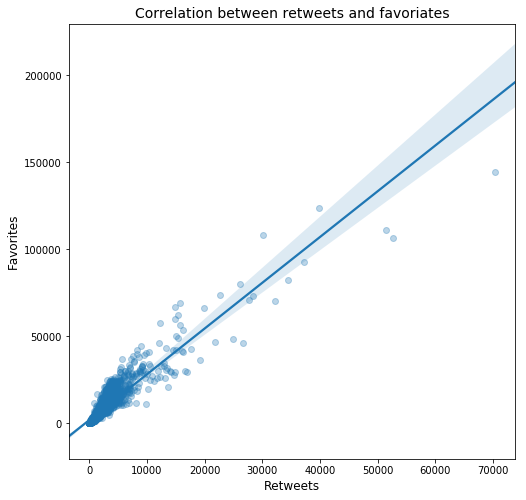

In [79]:
plt.figure(figsize=(8,8))

sns.regplot(x="retweet_count", y="favorite_count", data=twitter_archive_master, scatter_kws={'alpha':0.3})
plt.title('Correlation between retweets and favoriates', size=14)
plt.xlabel('Retweets', size=12)
plt.ylabel('Favorites', size=12)
#plt.show()
plt.savefig('retweetsVSfavoriates.png');



The plot above show us that the more a tweet get retweeted the more it spread over and get likes.

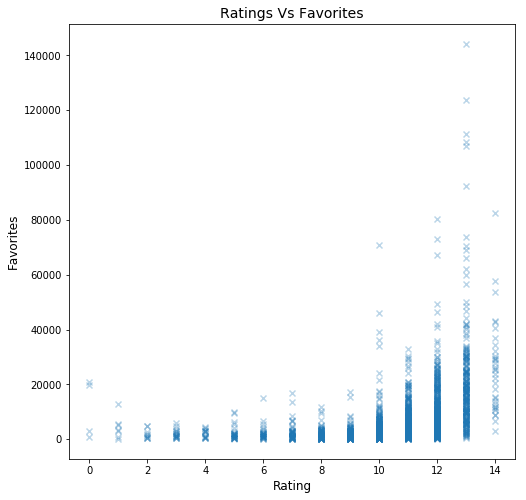

In [80]:
plt.figure(figsize=(8,8))

sns.regplot(x="rating_numerator", y="favorite_count", data = twitter_archive_master ,scatter_kws={'alpha':0.3} , marker='x' ,fit_reg=False);
plt.title('Ratings Vs Favorites', size=14)
plt.xlabel('Rating', size=12)
plt.ylabel('Favorites', size=12);
#plt.show()

plt.savefig('ratingVSfavorites.png')

The plot above shows that the higher the rates, the more it gets favorites.

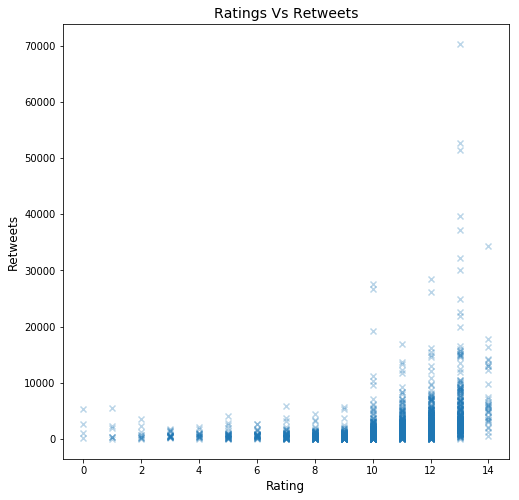

In [81]:
plt.figure(figsize=(8,8))

sns.regplot(x="rating_numerator", y="retweet_count", data = twitter_archive_master ,scatter_kws={'alpha':0.3} , marker='x' ,fit_reg=False);
plt.title('Ratings Vs Retweets', size=14)
plt.xlabel('Rating', size=12)
plt.ylabel('Retweets', size=12);
#plt.show()

plt.savefig('ratingVSretweets.png')


The plot above shows that the higher the rates, the more it gets retweets.

#### Top 10 dog breeds 

In [82]:
# display top 10 dog race predicted , Not forgetting to drop the 'NotDog' value counts since it will be irrelevant to our analyses
dog_breed =  twitter_archive_master['dog_breed'].value_counts().drop('NotDog')

In [83]:
dog_breed[:10]

Labrador_retriever          204
Chihuahua                   107
Pembroke                    101
French_bulldog               61
Pomeranian                   60
Chesapeake_Bay_retriever     47
Samoyed                      46
Siberian_husky               39
German_shepherd              31
Italian_greyhound            28
Name: dog_breed, dtype: int64

In [84]:
def hist(x , y ,x_lib ,y_lib ,title):
    plt.figure(figsize=(8,8))
    plt.bar(x, y, color=sns.color_palette('pastel'))
    plt.title(title, fontsize=10)
    plt.xlabel(x_lib, fontsize=10)
    plt.ylabel(y_lib, fontsize=10)
    plt.xticks(rotation=90, fontsize = 10)
    plt.yticks(fontsize = 10)
    #plt.show()
    plt.savefig(title+'.png')


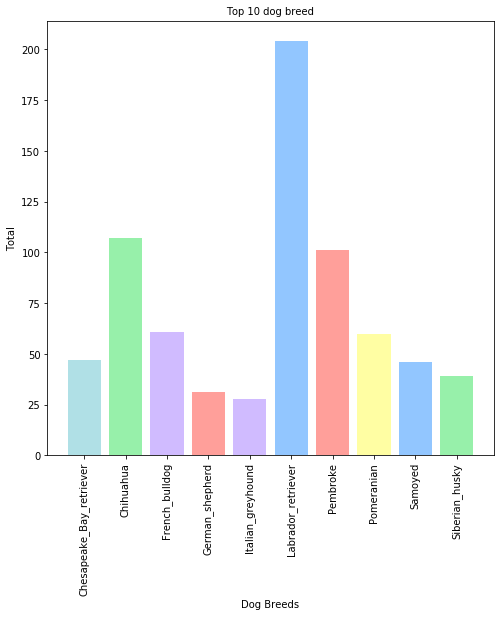

In [85]:
hist(dog_breed[:10].index, dog_breed[:10].values ,"Dog Breeds" ,"Total" ,"Top 10 dog breed")

The most common breed is Labrador retriever . We want to know now the correlation between retweets and rating for this breed.

In [86]:
Labrador_retriever = twitter_archive_master[twitter_archive_master['dog_breed'] == dog_breed.index[0]][["retweet_count","rating_numerator"]]

In [87]:
Labrador_retriever.head()

,retweet_count,rating_numerator
3,7191,13
14,1874,13
17,3513,13
31,5306,13
39,8221,13


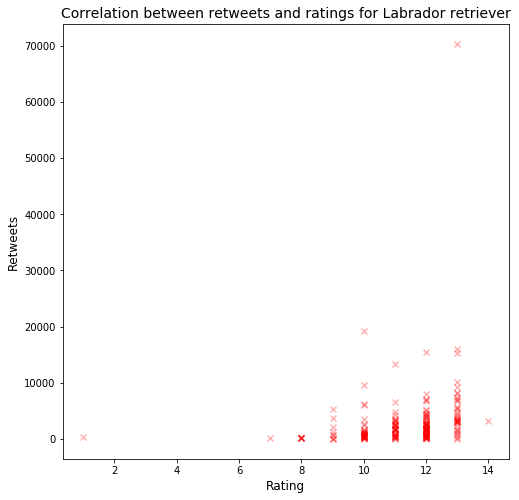

In [88]:
plt.figure(figsize=(8,8))

sns.regplot(x="rating_numerator", y="retweet_count", data = Labrador_retriever ,scatter_kws={'alpha':0.3} , marker='x',color='red' ,fit_reg=False);
plt.title('Correlation between retweets and ratings for Labrador retriever', size=14)
plt.xlabel('Rating', size=12)
plt.ylabel('Retweets', size=12);
#plt.show()

plt.savefig('Labrador_retriever.png');

#### Rating distribution

In [89]:
rates = twitter_archive_master['rating_numerator'].value_counts()

In [90]:
rates

12    441
10    411
11    391
13    249
9     148
8      98
7      53
14     33
6      33
5      31
3      19
4      16
2      10
1       7
0       4
Name: rating_numerator, dtype: int64

In [91]:
list(rates.index)

[12, 10, 11, 13, 9, 8, 7, 14, 6, 5, 3, 4, 2, 1, 0]

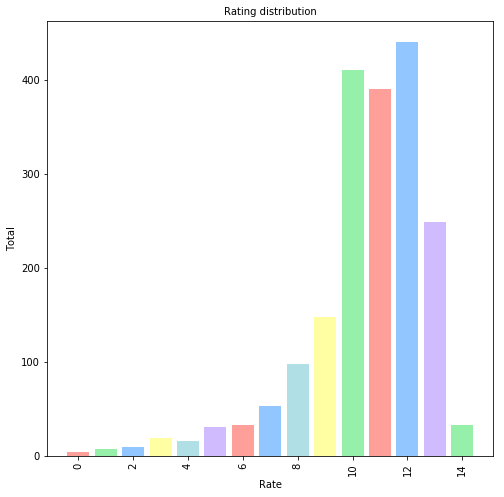

In [92]:
hist(list(rates.index), list(rates.values) ,"Rate" ,"Total" ,"Rating distribution")

We can see what rating are distributed above in the pics .The max rate is 14 and the min is 0.

#### Most common dog stage 

In [93]:
# display dog stage , Not forgetting to drop the 'Unkown' value counts since it will be irrelevant to our analyses

dog_stage = twitter_archive_master['dog_stage'].value_counts().drop("Unknown")

In [94]:
dog_stage.index

Index(['pupper', 'doggo', 'puppo', 'floofer'], dtype='object')

In [95]:
dog_stage.values

array([201,  62,  22,   7])

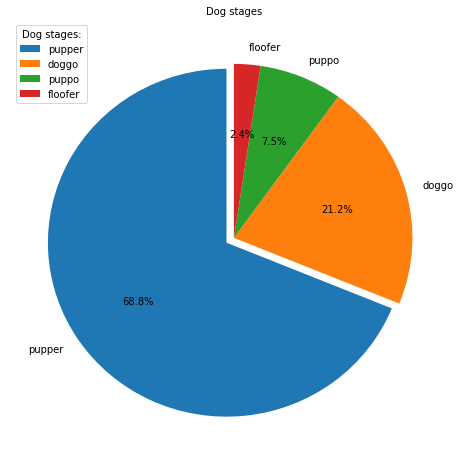

In [96]:
plt.figure(figsize=(8,8))
plt.pie(dog_stage.values, labels = dog_stage.index, autopct='%1.1f%%', explode=[0.05,0,0,0], startangle=90)
plt.title("Dog stages", fontsize=10)
plt.legend(title = "Dog stages:")
#plt.show() 
plt.savefig('Dog stages.png')

The most dog stage presented in this dataset is 'pupper'.We want to know now wether this stage recieves high ratings and retweets too

In [97]:
pupper = twitter_archive_master[twitter_archive_master['dog_stage'] == dog_stage.index[0]][["retweet_count","rating_numerator"]]

In [98]:
pupper.head()

,retweet_count,rating_numerator
28,2613,12
43,4077,12
49,13348,14
69,2795,12
76,3470,13


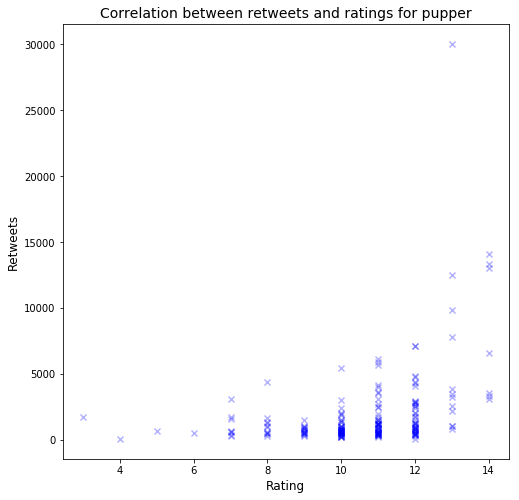

In [99]:
plt.figure(figsize=(8,8))

sns.regplot(x="rating_numerator", y="retweet_count", data = pupper ,scatter_kws={'alpha':0.3} , marker='x',color='blue' ,fit_reg=False);
plt.title('Correlation between retweets and ratings for pupper', size=14)
plt.xlabel('Rating', size=12)
plt.ylabel('Retweets', size=12);
#plt.show()

plt.savefig('pupper.png')

#### Does 'Labrador_retriever' represent a high percentage  'pupper'? 

In [100]:
dog_stage_breed = twitter_archive_master[(twitter_archive_master['dog_stage'] == 'pupper') & (twitter_archive_master['dog_breed'] == 'Labrador_retriever')]

In [101]:
dog_stage_breed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18 entries, 43 to 1590
Data columns (total 15 columns):
tweet_id              18 non-null int64
source                18 non-null object
text                  18 non-null object
expanded_urls         18 non-null object
rating_numerator      18 non-null int64
rating_denominator    18 non-null int64
name                  18 non-null object
dog_stage             18 non-null object
date                  18 non-null object
time                  18 non-null object
jpg_url               18 non-null object
img_num               18 non-null int64
dog_breed             18 non-null object
retweet_count         18 non-null int64
favorite_count        18 non-null int64
dtypes: int64(6), object(9)
memory usage: 2.2+ KB


The is only 10  puppers and Labrador retriever in this dataset.


In [102]:
pupper_breed = twitter_archive_master[twitter_archive_master ['dog_stage'] == 'pupper'].dog_breed.value_counts().drop("NotDog")


In [103]:
pupper_breed 

Labrador_retriever                18
Pembroke                          10
Chihuahua                          9
Pomeranian                         8
French_bulldog                     7
Samoyed                            5
Siamese_cat                        5
Lakeland_terrier                   5
Maltese_dog                        4
German_shepherd                    4
Siberian_husky                     4
Shetland_sheepdog                  4
Chesapeake_Bay_retriever           3
Norwegian_elkhound                 3
American_Staffordshire_terrier     3
Brabancon_griffon                  3
Border_collie                      3
Italian_greyhound                  2
Christmas_stocking                 2
Brittany_spaniel                   2
Eskimo_dog                         2
Boston_bull                        2
Rhodesian_ridgeback                2
Cardigan                           2
Bernese_mountain_dog               2
Great_Pyrenees                     2
Great_Dane                         2
Y

In [104]:
pupper_breed['Others'] = pupper_breed[5:].sum()
pupper_breed = pupper_breed.iloc[[0,1,2,3,4,-1]]
print(pupper_breed)

Labrador_retriever    18
Pembroke              10
Chihuahua              9
Pomeranian             8
French_bulldog         7
Others                98
Name: dog_breed, dtype: int64


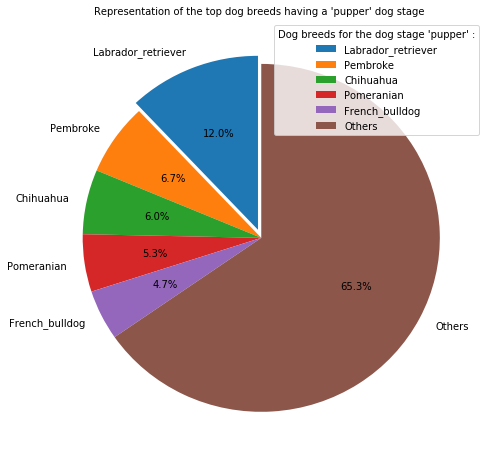

In [105]:
plt.figure(figsize=(8,8))
plt.pie(pupper_breed.values, labels = pupper_breed.index, autopct='%1.1f%%', explode=[0.05,0,0,0,0,0], startangle=90)
plt.title("Representation of the top dog breeds having a 'pupper' dog stage ", fontsize=10)
plt.legend(title = "Dog breeds for the dog stage 'pupper' :")
#plt.show() 
plt.savefig('pupperBreeds.png')


As we can see that Labrador retriever represents the biggest part of the pupper stage.


#### What is the most liked labrador retriever pupper

In [106]:
dog_stage_breed[dog_stage_breed['favorite_count'] == max(dog_stage_breed['favorite_count'].values)]

,tweet_id,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,date,time,jpg_url,img_num,dog_breed,retweet_count,favorite_count
215,837820167694528512,Twitter for iPhone,"Here's a pupper before and after being asked ""...",https://twitter.com/dog_rates/status/837820167...,12,10,Unknown,pupper,03-04-2017,00:21,https://pbs.twimg.com/media/C6CI_jbVAAA3-a1.jpg,1,Labrador_retriever,7133,31765


In [107]:
url_most = dog_stage_breed[dog_stage_breed['favorite_count'] == max(dog_stage_breed['favorite_count'].values)]['jpg_url']

In [108]:
url_most.values[0]

'https://pbs.twimg.com/media/C6CI_jbVAAA3-a1.jpg'

In [109]:
response = rq.get(url_most.values[0])
img = Image.open(BytesIO(response.content))

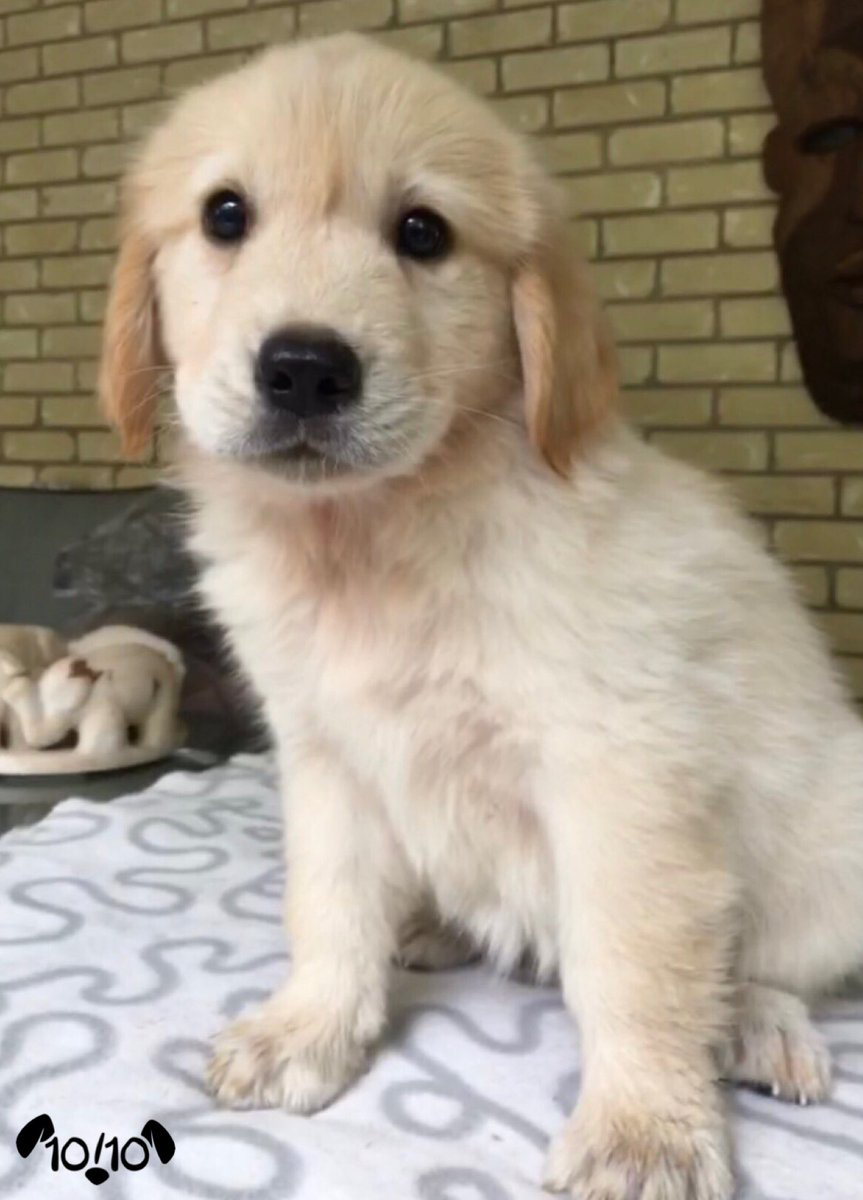

In [110]:
display(img)

In [123]:
img.save("most_liked.jpg")

#### Most used Twitter source 

In [124]:
twitter_archive_master.source.value_counts()

Twitter for iPhone    1907
Twitter Web Client      28
TweetDeck                9
Name: source, dtype: int64

In [4]:
#hist(twitter_archive_master.source.value_counts().index , twitter_archive_master.source.value_counts().values,'Souce','Total' , 'Most used Twitter source')

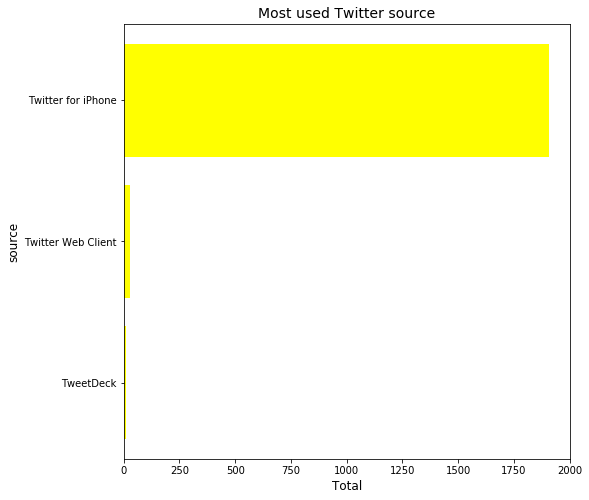

In [125]:
plt.figure(figsize=(8,8))

plt.barh(twitter_archive_master.source.value_counts().index,twitter_archive_master.source.value_counts().values , color = 'yellow')

plt.title('Most used Twitter source', size=14)
plt.xlabel('Total', size=12)
plt.ylabel('source', size=12);
#plt.show()
plt.savefig('Twitter source')

The most used source is Twitter for iphone.

#### Top 10 dog names

In [126]:
dog_names = twitter_archive_master.name.value_counts().drop('Unknown')

In [127]:
dog_names[:10].index

Index(['Cooper', 'Charlie', 'Oliver', 'Tucker', 'Lucy', 'Penny', 'Sadie',
       'Winston', 'Daisy', 'Toby'],
      dtype='object')

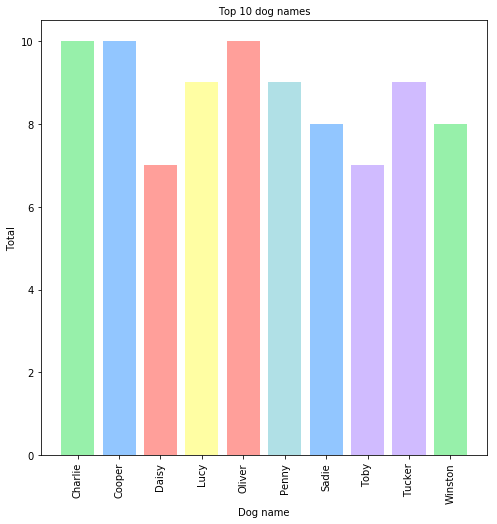

In [128]:
hist(dog_names[:10].index ,dog_names[:10].values,'Dog name','Total' , 'Top 10 dog names')

'Charlie', 'Cooper' and 'Oliver' are the most common dog names in ths dataset.

#### Peak hours 

In [129]:
twitter_archive_master.time[0].split(':')[0]

'16'

In [130]:
hours = [] 
for time in twitter_archive_master.time:
    hours.append(time.split(':')[0])

In [131]:
h = Counter(hours) #we can  see some missing hours we will add them manually

In [132]:
h  #we can  see some missing hours we will add them manually

Counter({'16': 185,
         '00': 248,
         '15': 89,
         '01': 270,
         '17': 156,
         '03': 164,
         '23': 108,
         '20': 75,
         '22': 67,
         '21': 68,
         '19': 81,
         '18': 98,
         '14': 8,
         '04': 94,
         '02': 205,
         '06': 3,
         '05': 24,
         '13': 1})

In [133]:
h['07'] = 0
h['08'] = 0
h['09'] = 0
h['10'] = 0
h['11'] = 0
h['12'] = 0

In [134]:
df_hours = pd.DataFrame(h.most_common(len(h)), columns=['hour', 'total_per_hour']).sort_values('hour')

In [135]:
df_hours = df_hours.set_index('hour')

In [136]:
df_hours

,total_per_hour
hour,
00,248
01,270
02,205
03,164
04,94
05,24
06,3
07,0
08,0


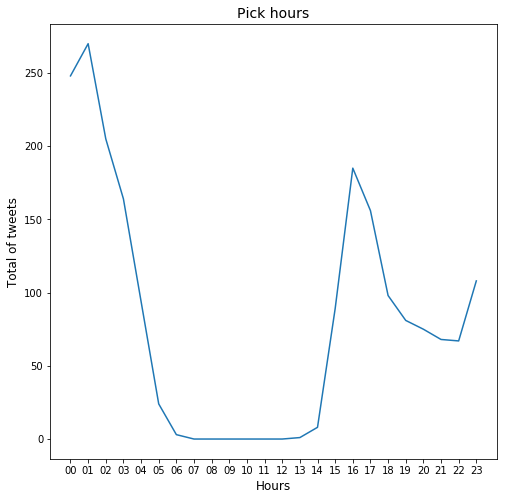

In [137]:
plt.figure(figsize=(8,8))
plt.plot(df_hours["total_per_hour"])

plt.title("Pick hours", fontsize=14)
plt.xlabel("Hours", fontsize=12)
plt.ylabel("Total of tweets", fontsize=12)
#plt.show()
plt.savefig('Pick_hours')


As we can notice the pick hours are between 11pm and 3am and 15pm and 18pm.